In [ ]:
!pip install wfdb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.0/160.0 kB 2.8 MB/s eta 0:00:00


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd
pd.set_option('display.max_columns', None)

import wfdb
import glob
import os

In [ ]:
from scipy import signal as scipy_signal

def load_signal_using_wfdb(file, start, end, channel, pn_dir):
    """
    file: name of record
    start: int
    end:int
    channel: 0 or 1
    """
    record = wfdb.rdrecord(file, sampfrom = start, sampto = end, channels=[channel], pn_dir=pn_dir)
    data = record.p_signal.reshape(-1)
    return data

def split_vector_into_chunk(vector, size_chunk:int):
    len_vector = len(vector)
    num_chunks = int(len_vector//size_chunk)
    list_chunks = []

    for i in range(0, num_chunks*size_chunk, size_chunk):
        list_chunks.append(vector[i:i+size_chunk])

    return list_chunks

def cut_signal_into_segments(signal, sampling_rate, duration):
    num_samples_received_after_duration = duration*sampling_rate
    return split_vector_into_chunk(signal, num_samples_received_after_duration)

def synchronize_signal(signal, sampling_rate, common_sampling_rate):

    num_samples = int((common_sampling_rate*len(signal))/sampling_rate)
    signal_resampled = scipy_signal.resample(signal, num_samples)

    return signal_resampled

In [ ]:
nsr_list = wfdb.get_record_list('nsrdb')
nsr = [] # 128Hz 1 chan
for record_name in nsr_list:
    signal = load_signal_using_wfdb(record_name, start=0, end=7680, channel=0, pn_dir='nsrdb')
    nsr.append(signal)

arr_list = wfdb.get_record_list('mitdb')
arr = [] # 360Hz 2 chan
for record_name in arr_list:
    signal = load_signal_using_wfdb(record_name, start=0, end=21600, channel=0, pn_dir='mitdb')
    arr.append(signal)

chf_list = wfdb.get_record_list('chfdb')
chf = [] #250Hz 1 chan
for record_name in chf_list:
    signal = load_signal_using_wfdb(record_name, start=0, end=15000, channel=0, pn_dir='chfdb')
    chf.append(signal)


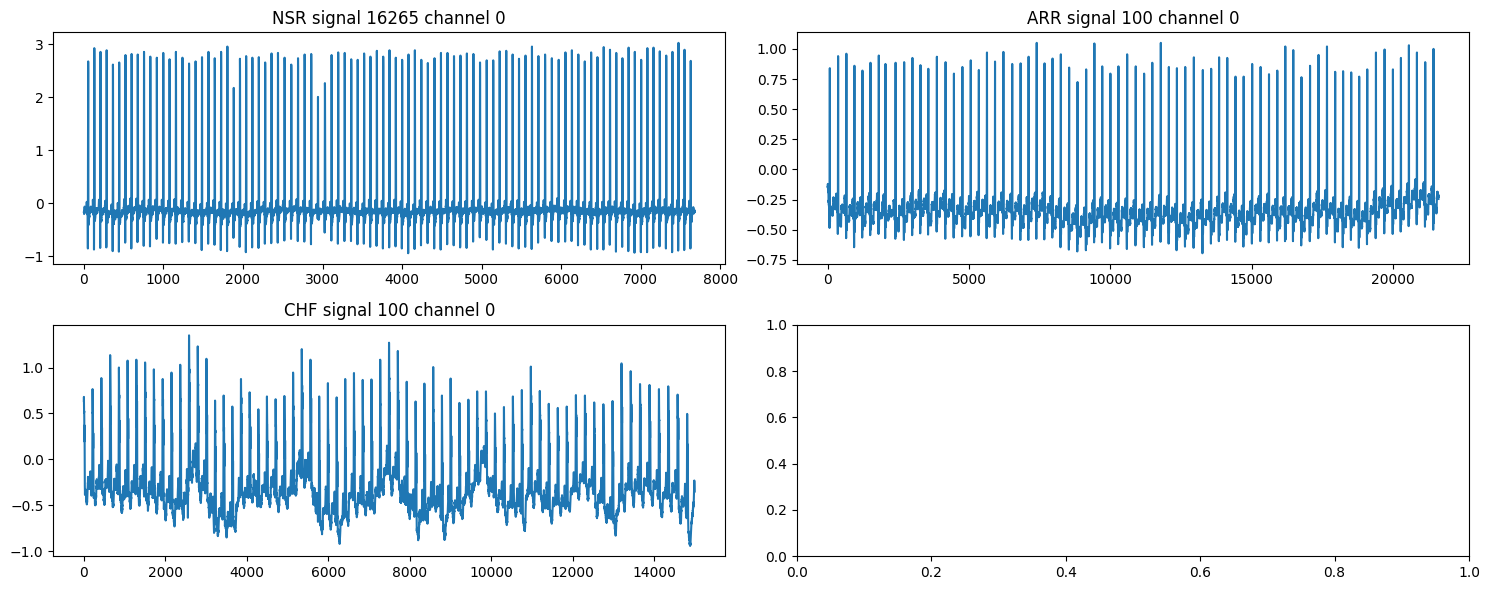

In [ ]:
# Create a figure and 4 subplots
fig, axs = plt.subplots(2, 2, figsize=(15, 6))  # 2x2 grid of subplots

# Plot data on each subplot
axs[0, 0].plot(nsr[0])
axs[0, 0].set_title("NSR signal 16265 channel 0")

axs[0, 1].plot(arr[0])
axs[0, 1].set_title("ARR signal 100 channel 0")

axs[1, 0].plot(chf[0])
axs[1, 0].set_title("CHF signal 100 channel 0")

# Adjust the layout so titles/labels don't overlap
plt.tight_layout()

# Display the figure with subplots
plt.show()

In [ ]:
print("ARR signal number :", len(arr))
print("CHF signal number :", len(chf))
print("NSR signal number :", len(nsr))

ARR signal number : 48
CHF signal number : 15
NSR signal number : 18


**Resampling the signals to 128Hz**

In [ ]:
arr_resampled = [synchronize_signal(sig, 360, 128) for sig in arr]
chf_resampled = [synchronize_signal(sig, 250, 128) for sig in chf]

**Checking all signal are now the same length**

In [ ]:
print("Arr signal length: ", len(arr_resampled[0]))
print("Chf signal length: ", len(chf_resampled[0]))
print("Nsr signal length: ", len(nsr[0]))

Arr signal length:  7680
Chf signal length:  7680
Nsr signal length:  7680


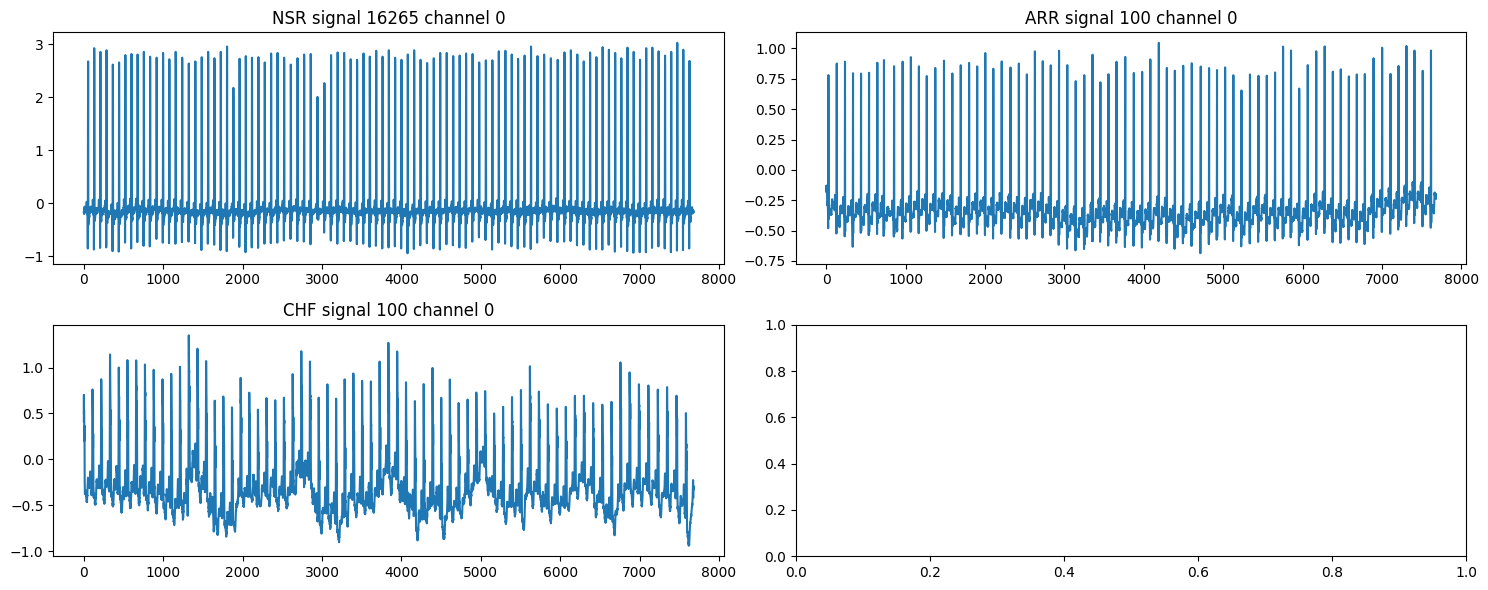

In [ ]:
# Create a figure and 4 subplots
fig, axs = plt.subplots(2, 2, figsize=(15, 6))  # 2x2 grid of subplots

# Plot data on each subplot
axs[0, 0].plot(nsr[0])
axs[0, 0].set_title("NSR signal 16265 channel 0")

axs[0, 1].plot(arr_resampled[0])
axs[0, 1].set_title("ARR signal 100 channel 0")

axs[1, 0].plot(chf_resampled[0])
axs[1, 0].set_title("CHF signal 100 channel 0")

# Adjust the layout so titles/labels don't overlap
plt.tight_layout()

# Display the figure with subplots
plt.show()

**Cut signal to 5 secs**

In [ ]:
nsr_short = [sig[:640] for sig in nsr]
arr_short = [sig[:640] for sig in arr_resampled]
chf_short = [sig[:640] for sig in chf_resampled]

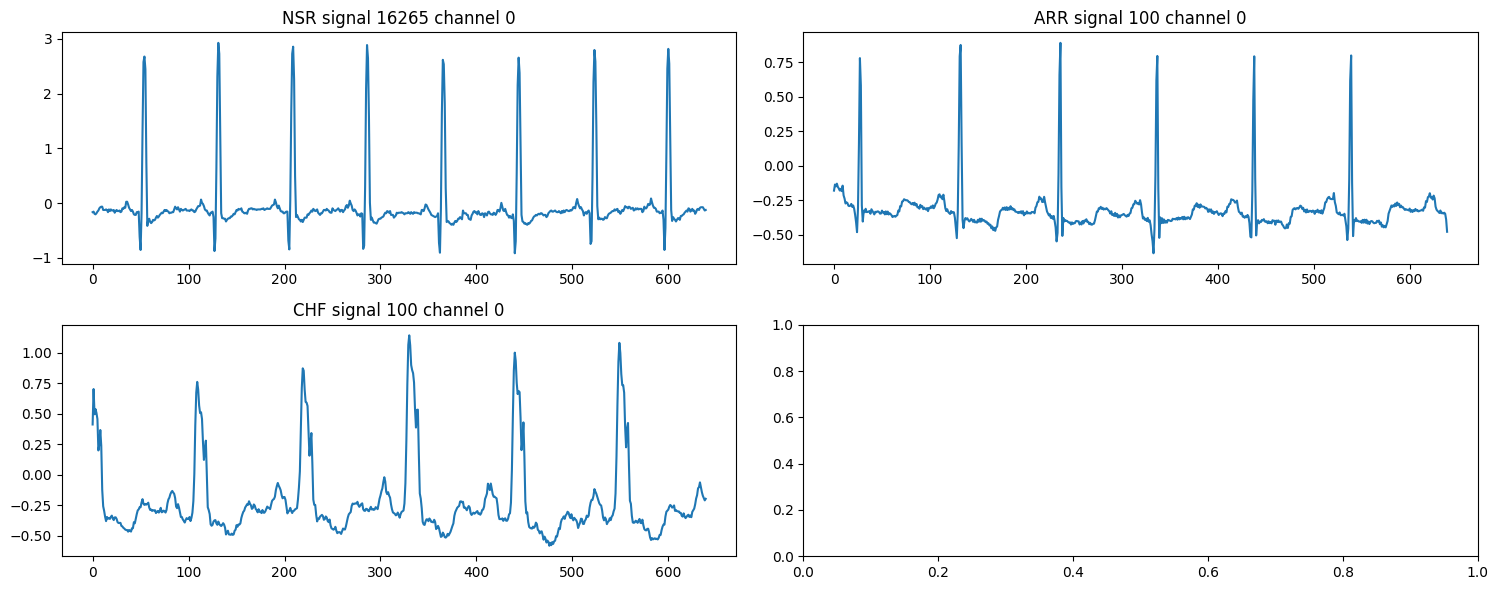

In [ ]:
# Create a figure and 4 subplots
fig, axs = plt.subplots(2, 2, figsize=(15, 6))  # 2x2 grid of subplots

# Plot data on each subplot
axs[0, 0].plot(nsr_short[0])
axs[0, 0].set_title("NSR signal 16265 channel 0")

axs[0, 1].plot(arr_short[0])
axs[0, 1].set_title("ARR signal 100 channel 0")

axs[1, 0].plot(chf_short[0])
axs[1, 0].set_title("CHF signal 100 channel 0")

# Adjust the layout so titles/labels don't overlap
plt.tight_layout()

# Display the figure with subplots
plt.show()

**Dataset**

In [ ]:
from sklearn.model_selection import train_test_split

X = np.concatenate([nsr_short, arr_short, chf_short])
y = np.repeat([0, 1, 2], [18, 48, 15])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

**1D Convolution**

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout

model = Sequential([
    Conv1D(filters=64, kernel_size=5, activation='relu', input_shape=(640, 1)),
    MaxPooling1D(pool_size=2),

    Conv1D(filters=128, kernel_size=5, activation='relu'),
    MaxPooling1D(pool_size=2),

    Flatten(),

    Dense(128, activation='relu'),
    Dropout(0.5),

    Dense(3, activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

print(model.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_6 (Conv1D)           (None, 636, 64)           384       
                                                                 
 max_pooling1d_6 (MaxPoolin  (None, 318, 64)           0         
 g1D)                                                            
                                                                 
 conv1d_7 (Conv1D)           (None, 314, 128)          41088     
                                                                 
 max_pooling1d_7 (MaxPoolin  (None, 157, 128)          0         
 g1D)                                                            
                                                                 
 flatten_3 (Flatten)         (None, 20096)             0         
                                                                 
 dense_6 (Dense)             (None, 128)              

In [ ]:
history = tf.keras.callbacks.History()

In [ ]:
model.fit(X_train, y_train, epochs=10, callbacks=[history])

Epoch 1/10
2/2 [==============================] - 1s 145ms/step - loss: 1.2125 - accuracy: 0.4062
Epoch 2/10
2/2 [==============================] - 0s 127ms/step - loss: 0.8782 - accuracy: 0.6250
Epoch 3/10
2/2 [==============================] - 0s 148ms/step - loss: 0.7580 - accuracy: 0.7031
Epoch 4/10
2/2 [==============================] - 0s 203ms/step - loss: 0.6733 - accuracy: 0.7031
Epoch 5/10
2/2 [==============================] - 0s 191ms/step - loss: 0.5589 - accuracy: 0.7969
Epoch 6/10
2/2 [==============================] - 0s 209ms/step - loss: 0.4643 - accuracy: 0.8281
Epoch 7/10
2/2 [==============================] - 0s 205ms/step - loss: 0.3717 - accuracy: 0.8281
Epoch 8/10
2/2 [==============================] - 0s 189ms/step - loss: 0.2677 - accuracy: 0.9062
Epoch 9/10
2/2 [==============================] - 0s 201ms/step - loss: 0.2365 - accuracy: 0.8750
Epoch 10/10
2/2 [==============================] - 0s 194ms/step - loss: 0.1876 - accuracy: 0.9062


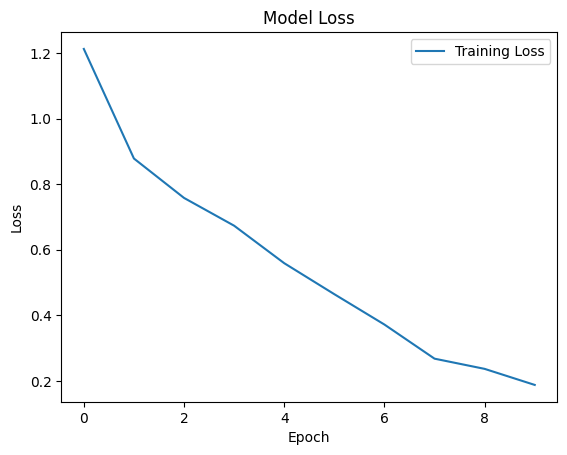

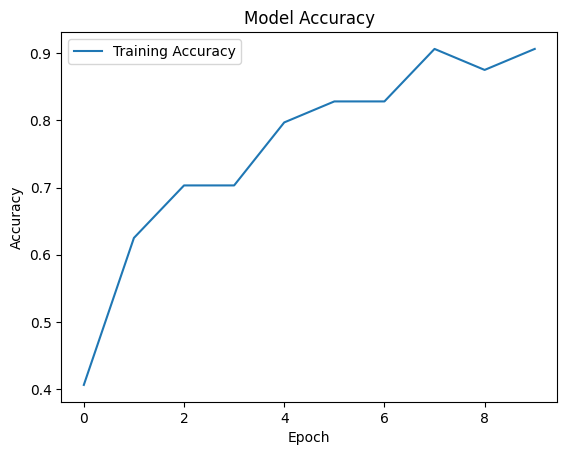

In [ ]:
import matplotlib.pyplot as plt

loss = history.history['loss']
acc = history.history['accuracy']

plt.plot(history.history['loss'], label='Training Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

**Accuracy**

In [ ]:
model.evaluate(X_test, y_test)

1/1 [==============================] - 0s 201ms/step - loss: 0.8014 - accuracy: 0.7059


[0.8014206886291504, 0.7058823704719543]

L'accuracy avec un modèle de convolution 1D sur des samples de 128hZ qui durent 5 secondes est de 70%.